In [1]:
import os
os.chdir('..')

import ml.model
import inputgenerator
from tensorflow.keras.layers import *  # noqa
from tensorflow.keras.losses import *
import numpy as np
from sklearn.preprocessing import StandardScaler

# Simple LSTM model to predict x^2

In [3]:
input = Input(shape=(1,1))
lstm = LSTM(4, return_sequences=True)
lstm2 = LSTM(4)
output = Dense(1, activation='linear')
model = ml.model.SimpleModel(None, layers = [input, lstm,lstm2,  output], optimizer='adam', loss='msle', validation_split=0.01, epochs=500, shuffle=True)
model.initialize()

In [4]:
x = np.array(range(-5000,5000)).reshape(-1,1)
y = np.array([x^3 for x in range(-5000,5000)]).reshape(-1,1) 
scalerX = StandardScaler()
scalerY = StandardScaler()
x_scaled = np.array([[x] for x in scalerX.fit_transform(x)]).reshape(-1,1,1)
y_scaled = np.array([[y] for y in scalerY.fit_transform(y)]).reshape(-1,1,1)

model.train(x_scaled,y_scaled)

Epoch 1/500
290/310 [===========================>..] - ETA: 0s - loss: 0.0928
Epoch 00001: val_loss improved from inf to 0.10182, saving model to best_model.h5
310/310 [==============================] - 1s 4ms/step - loss: 0.0881 - val_loss: 0.1018
Epoch 2/500
306/310 [============================>.] - ETA: 0s - loss: 0.0041
Epoch 00002: val_loss improved from 0.10182 to 0.00743, saving model to best_model.h5
310/310 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0074
Epoch 3/500
310/310 [==============================] - ETA: 0s - loss: 3.1209e-04
Epoch 00003: val_loss improved from 0.00743 to 0.00403, saving model to best_model.h5
310/310 [==============================] - 1s 2ms/step - loss: 3.1209e-04 - val_loss: 0.0040
Epoch 4/500
286/310 [==========================>...] - ETA: 0s - loss: 2.6949e-04
Epoch 00004: val_loss improved from 0.00403 to 0.00335, saving model to best_model.h5
310/310 [==============================] - 1s 2ms/step - loss: 2.6736

In [5]:
import matplotlib.pyplot as plt
plt.plot(y)
plt.plot(scalerY.inverse_transform(model.model.predict(x_scaled)))

# Predict BTC Close

In [2]:
import dataloader
import inputgenerator
df = dataloader.get_all_data('BTCUSDT', '30m')

1800000


In [3]:
ig = inputgenerator.InputGeneratorRegression(None, '30m', 32, 1, ['Close', 'High', 'Low'], 'High', output_granularity='2h', scale=True)
x, y = ig.get_input_for_training(df)

In [10]:
input = Input(shape=(len(ig.features) * ig.iw))
reshape = Reshape((ig.iw, len(ig.features)))
bn = BatchNormalization()
lstm = LSTM(32)
output = Dense(1, activation='linear')
model = ml.model.SimpleModel(None, layers = [input,reshape,bn,lstm, output], optimizer='adam', loss='mse', validation_split=0.01, epochs=500, shuffle=True, batch_size=1000)
model.initialize()



In [11]:

model.train(x,y)

Epoch 1/500
51/52 [============================>.] - ETA: 0s - loss: 0.2586
Epoch 00001: val_loss improved from inf to 0.01150, saving model to best_model.h5
52/52 [==============================] - 2s 44ms/step - loss: 0.2558 - val_loss: 0.0115
Epoch 2/500
51/52 [============================>.] - ETA: 0s - loss: 0.0213
Epoch 00002: val_loss improved from 0.01150 to 0.00378, saving model to best_model.h5
52/52 [==============================] - 2s 36ms/step - loss: 0.0211 - val_loss: 0.0038
Epoch 3/500
51/52 [============================>.] - ETA: 0s - loss: 0.0102
Epoch 00003: val_loss did not improve from 0.00378
52/52 [==============================] - 2s 34ms/step - loss: 0.0102 - val_loss: 0.0054
Epoch 4/500
51/52 [============================>.] - ETA: 0s - loss: 0.0084
Epoch 00004: val_loss did not improve from 0.00378
52/52 [==============================] - 2s 34ms/step - loss: 0.0084 - val_loss: 0.0062
Epoch 5/500
51/52 [============================>.] - ETA: 0s - loss: 0.008

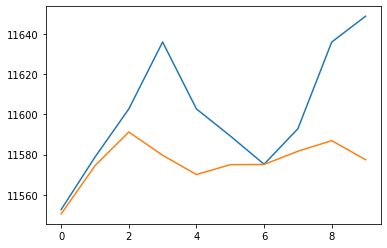

In [15]:
import matplotlib.pyplot as plt
y_true = ig.scalerY.inverse_transform(y[-5000:])
y_pred = ig.scalerY.inverse_transform(model.model.predict(x[-5000:]))
plt.plot(y_true[-10:])
plt.plot(y_pred[-10:])

In [13]:
model.model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 32, 3)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 3)             12        
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                4608      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 4,653
Trainable params: 4,647
Non-trainable params: 6
_________________________________________________________________


In [14]:
from sklearn import metrics
metrics.mean_absolute_error(y_true, y_pred)

58.36853660285888

In [ ]:
# Prod


In [6]:

import dataloader
import inputgenerator
df = dataloader.get_all_data('BTCUSDT', '30m')

In [2]:
ig = inputgenerator.InputGeneratorRegression('max', '30m', 64, 1, ['Close', 'High', 'Low', 'Vol', 'Quote_Asset_Vol', 'Trades', 'Base_Vol', 'Quote_Vol'], 'High', output_granularity='1h', scale=True)
model = ml.model.SimpleModel(ig, layers = [Input(shape=(len(ig.features) * ig.iw)),ml.model.Reshape((len(ig.features), ig.iw)),ml.model.Permute((2, 1)),BatchNormalization(),LSTM(2), Dense(1, activation='linear')], optimizer='adam', loss='mse', validation_split=0.05, epochs=1, shuffle=True, batch_size=1000)
model.initialize()

In [11]:
issubclass(type(model.model.layers[3]), RNN)


True

In [13]:
def kr_to_str(kr):
    return str(kr)

def layer_to_str(layer):
    layer_class = type(layer)
    class_name = type(layer_class).__name__
    if layer_class == LSTM or layer_class == Dense or layer_class == GRU:
        name = "{}\nUnits: {}\n".format(class_name, layer.units)
        if layer.dropout > 0:
            name = name + "\nDropout: {}".format(layer.dropout)
        if layer.kernel_regularizer is not None:
            name = name + "\nKr: {}".format(kr_to_str(layer.kernel_regularizer))    
    else:
        name = class_name
    return name
    
def model_to_str(model):
    model_class = type(model)
    class_name = type(model_class).__name__
    if model_class == ml.model.SimpleModel:
        return "{}\n{}\n{}".format(class_name, '\n'.join([layer_to_str(x) for x in model.model.layers], ig_to_str(model.ig)))
    else
        return class_name

def ig_to_str(ig : InputGenerator):    
    return "{}\n{}\n{}".format(ig.granularity, str(ig.iw), ig.features)

SyntaxError: invalid syntax (<ipython-input-13-bcb34f06408b>, line 21)

In [15]:
train_utils.train_model_prod(df, model, 'high')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 8, 64)             0         
_________________________________________________________________
permute_2 (Permute)          (None, 64, 8)             0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 8)             32        
_________________________________________________________________
lstm_2 (LSTM)                (None, 2)                 88        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 123
Trainable params: 107
Non-trainable params: 16
_________________________________________________________________
None
Train start: 2017-08-18 11:30:00
Train end: 2020-12-26 21:30:00
56/56 [==============================] - 3s 29ms/ste

In [9]:
import train_utils

In [16]:
import sklearn
sklearn.__version__

'0.21.3'